导言：

这算是第一个真正意义上独立完成的Kaggle项目。期间参考了许多大神的做法，受益匪浅。本人技术不精，况且又是第一次做Kaggle的项目，请各位读者谅解，如有问题还请各位提出。谢谢大家的支持。

# 数据包与数据集导入

In [724]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [725]:
train = pd.read_csv('~/Coding/Kaggle/Titanic/train.csv')
test = pd.read_csv('~/Coding/Kaggle/Titanic/test.csv')
combine = pd.concat([train, test], sort = False, ignore_index=True)
PassengerId = test['PassengerId']

# 数据分析

## 概览

In [726]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


我们不难看出，原始数据包括
*PassengerId, Survived, Pclass, Name, Sex, Age, Sibsp, Parch, Ticket, Fare, Cabin, Embarked*
这几个类目。

In [727]:
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


## 各类目数据类型和缺省值

接下来我们分析训练数据类目的类型以及其缺省值。

In [728]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [729]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


从上可以看出：
1. train中，*Age和Cabin*有缺少
2. test中，*Age, Fare and Cabin*有缺少

## 数据初步分析

继续分析

In [730]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


通过上述结果，发现：
1. *PassengerId*是unique的，与目标无关，在训练集中可以舍去
2. 最终结果*Survived*是0，1表示的
3. 很多人都没有直系亲属或旁系亲属
4. 只有很少的人支付512美元的船票
5. 登船人员的年龄普遍不是很大

我们首先将*PassengerId*条目在训练集中删去

紧接着，我们来观察非numeric的值

In [731]:
train.describe(include=['O'])# 注意，这个‘O’是 大写的‘o’，而不是数字0

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Ibrahim Shawah, Mr. Yousseff",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


发现：
1. 乘客大部分为男士
2. Ticket中有210张同样的票
3. 大部分人从S港口登船

### 下面分析各类目与*Survived*之间的相互关系。

1. Sex feature

观察男女的生存率差异

In [732]:
train[['Sex', 'Survived']].groupby('Sex', as_index=False).mean()\
.sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


女性的生存率普遍高于男性，Sex是较为重要的一个条目，需要保留。

2. Pclass

In [733]:
train[['Pclass', 'Survived']].groupby('Pclass', as_index=False).mean()\
.sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Pclass数值越小，生存几率越大。

3. SibSp和Parch

In [734]:
train[['SibSp', 'Survived']].groupby('SibSp', as_index=False).mean()\
.sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [735]:
train[['Parch', 'Survived']].groupby('Parch', as_index=False).mean()\
.sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


在这边其实可以考虑将Parch和SibSp合并成FamilySize

4. Embarked

In [736]:
train[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean()\
.sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


C港口登船的船员生存率最高

5. Ticket

In [737]:
train[['Ticket', 'Survived']].groupby('Ticket', as_index=False).mean()\
.sort_values(by='Survived', ascending=False).head()

,Ticket,Survived
0,110152,1.0
180,26360,1.0
483,386525,1.0
479,382651,1.0
151,244373,1.0


关于登船人员的票证，因为特异值太多，可以考虑数据清洗时将其根据相同票证进行分组

6. Age
由于Age是连续值，所以我们的分析通过图像来进行。

Text(12.359751157407416, 0.5, 'density')

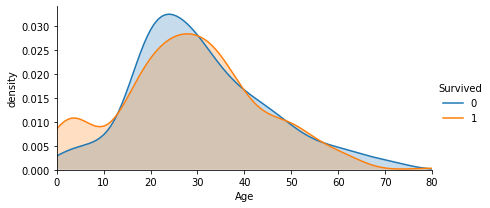

In [738]:
facet = sns.FacetGrid(train, hue='Survived', aspect=2)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age')
plt.ylabel('density')

通过年龄-生存密度图可以看出，两曲线形状大部分重叠，只有在15岁以下生存率有差别。可以将年龄较低的部分单独分组。

7. Fare

Text(11.594234664351859, 0.5, 'density')

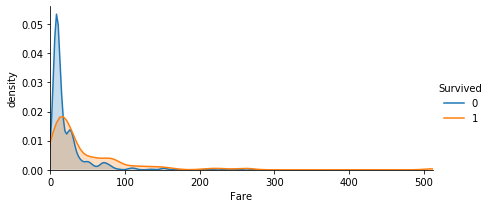

In [739]:
far = sns.FacetGrid(train, hue='Survived', aspect=2)
far.map(sns.kdeplot, 'Fare', shade=True)
far.set(xlim=(0, train['Fare'].max()))
far.add_legend()
plt.xlabel('Fare')
plt.ylabel('density')

150之后的fare可以分为一组。0-25分组，25-100分组，100-150分组。

8. Cabin

In [740]:
train['Cabin'].value_counts(dropna=True).head()

C23 C25 C27    4
B96 B98        4
G6             4
F2             3
D              3
Name: Cabin, dtype: int64

可以看出Cabin的数量非常多，在后面处理时会考虑只提取第一个字母来进行训练。

9. Name

有关Name的这一部分将会在下面特征提取部分涉及。

## 特征提取

 需要注意的是，接下来的特征提取以及数据清洗的阶段需要对整个数据集进行。

1. FamilySize

将Parch和SibSp相加并加上1.

In [741]:
combine['FamilySize'] = combine['Parch'] + combine['SibSp'] + 1
combine = combine.drop(['Parch', 'SibSp'], axis=1)

处理完成之后我们再观察新创立的FamilySize。

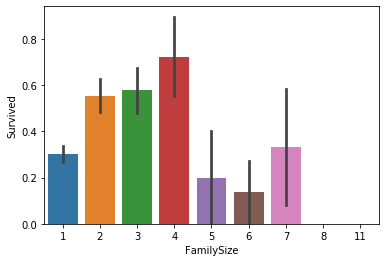

In [742]:
sns.barplot(x='FamilySize', y='Survived', data=combine)

我们将*FamilySize*分成三组。

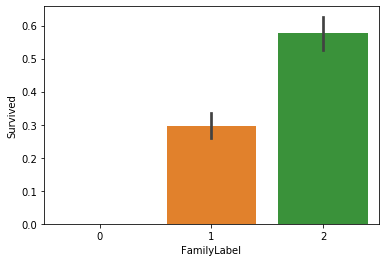

In [743]:
def fam(d):
    if (d>=2) & (d<=4):
        return 2
    elif ((d>4) & (d<=7)) | (d==1):
        return 1
    elif (d>7):
        return 0
    
combine['FamilyLabel'] = combine['FamilySize'].apply(fam)
sns.barplot(x='FamilyLabel', y='Survived', data=combine)

对*FamilySize*进行丢弃。

In [744]:
combine = combine.drop('FamilySize', axis=1)

2. 对Cabin进行提取

首先将*Cabin*数据丢失的部分进行填充

In [745]:
combine['Cabin'] = combine['Cabin'].fillna('Unknown')

紧接着我们创建*Deck*属性，即对*Cabin*第一字母的提取。

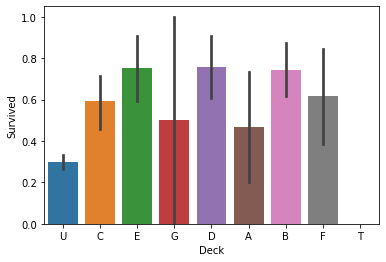

In [746]:
combine['Deck'] = combine['Cabin'].str.get(0)
sns.barplot(x='Deck', y='Survived', data=combine)

对*Cabin*进行丢弃。

In [747]:
combine = combine.drop('Cabin', axis=1)

将Deck进行分组。

In [748]:
deck_dict = {}
deck_dict.update(dict.fromkeys(['C', 'E', 'D', 'B', 'F'], 1))
deck_dict.update(dict.fromkeys(['U', 'G', 'A', 'T'], 0))

#combine['Deck'] = combine['Deck'].map(deck_dict)
#combine['Deck'] = combine['Deck'].astype(int)

3. Ticket

主要是对Ticket进行分组。

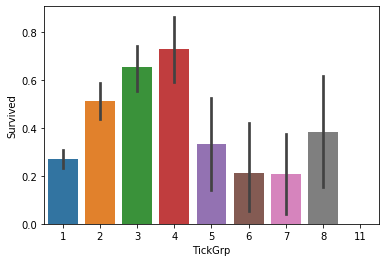

In [749]:
Tik_num = dict(combine['Ticket'].value_counts())
combine['TickGrp'] = combine['Ticket'].apply(lambda x: Tik_num[x])
sns.barplot(x='TickGrp', y='Survived', data=combine)


In [750]:
combine = combine.drop('Ticket', axis=1)

将TickGrp分成三组。

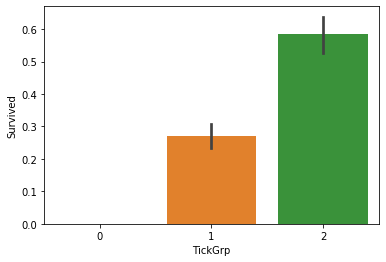

In [751]:
def tic(s):
    if (s>=2) & (s<=4):
        return 2
    elif ((s>4) & (s<=8)) | (s==1):
        return 1
    elif (s>8):
        return 0

combine['TickGrp'] = combine['TickGrp'].apply(tic)
sns.barplot(x='TickGrp', y='Survived', data=combine)

4. Name

具体某一位乘客的姓名肯定是和生存率无关。*Name*中有作用的成分应该是其中的Title。

下面提取出每个人的Title并创建新的*Title*条目。

In [752]:
combine['Title'] = combine['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
pd.crosstab(combine['Title'], combine['Survived'])

Survived,0.0,1.0
Title,,
Capt,1,0
Col,1,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,1,1
Master,17,23
Miss,55,127


In [753]:
combine = combine.drop('Name', axis=1)

我们需要将*Title*分类。

In [754]:
title_dict = {}
title_dict.update(dict.fromkeys(['Lady', 'the Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare'))
title_dict.update(dict.fromkeys(['Mlle'], 'Miss'))
title_dict.update(dict.fromkeys(['Ms'], 'Miss'))
title_dict.update(dict.fromkeys(['Mme'], 'Mrs'))
title_dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_dict.update(dict.fromkeys(['Mrs'], 'Mrs'))
title_dict.update(dict.fromkeys(['Master'], 'Master'))

combine['Title'] = combine['Title'].map(title_dict)
combine[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()\
.sort_values(by='Survived', ascending=False)

,Title,Survived
1,Miss,1.000000
3,Mrs,0.793651
0,Master,0.575000
4,Rare,0.347826
2,Mr,0.156673


In [755]:
#title_mapping = {"Mr": 1, "Miss": 5, "Mrs": 4, "Master": 3, "Rare": 2}
#combine['Title'] = combine['Title'].map(title_mapping)
#combine['Title'] = combine['Title'].fillna(0)

5. 把*Sex*转换为数字

In [756]:
#combine['Sex'] = combine['Sex'].map( {'female': 1, 'male': 0} )

In [757]:
#combine.head()

## 数据清洗

1. 将Embarked缺省值用众数填充

In [758]:
freq_port = combine.Embarked.dropna().mode()[0]
freq_port

'S'

In [759]:
combine['Embarked'] = combine['Embarked'].fillna(freq_port)
combine[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()\
.sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [760]:
#combine['Embarked'] = combine['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilyLabel,Deck,TickGrp,Title
0,1,0.0,3,male,22.0,7.2500,S,2,U,1,Mr
1,2,1.0,1,female,38.0,71.2833,C,2,C,2,Mrs
2,3,1.0,3,female,26.0,7.9250,S,1,U,1,NaN
3,4,1.0,1,female,35.0,53.1000,S,2,C,2,Mrs
4,5,0.0,3,male,35.0,8.0500,S,1,U,1,Mr


2. Fare

我们用Fare的平均数来填充Nan

In [761]:
combine['Fare'].fillna(combine['Fare'].dropna().median(), inplace=True)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilyLabel,Deck,TickGrp,Title
0,1,0.0,3,male,22.0,7.2500,S,2,U,1,Mr
1,2,1.0,1,female,38.0,71.2833,C,2,C,2,Mrs
2,3,1.0,3,female,26.0,7.9250,S,1,U,1,NaN
3,4,1.0,1,female,35.0,53.1000,S,2,C,2,Mrs
4,5,0.0,3,male,35.0,8.0500,S,1,U,1,Mr


创建*FareBand*

In [762]:
combine['FareBand'] = pd.qcut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean()\
.sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197309
1,"(7.896, 14.454]",0.303571
2,"(14.454, 31.275]",0.441048
3,"(31.275, 512.329]",0.600000


In [763]:
combine.loc[ combine['Fare'] <= 7.91, 'Fare'] = 0
combine.loc[(combine['Fare'] > 7.91) & (combine['Fare'] <= 14.454), 'Fare'] = 1
combine.loc[(combine['Fare'] > 14.454) & (combine['Fare'] <= 31), 'Fare']   = 2
combine.loc[ combine['Fare'] > 31, 'Fare'] = 3
combine['Fare'] = combine['Fare'].astype(int)

In [764]:
combine = combine.drop('FareBand', axis=1)

In [765]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilyLabel,Deck,TickGrp,Title
0,1,0.0,3,male,22.0,0,S,2,U,1,Mr
1,2,1.0,1,female,38.0,3,C,2,C,2,Mrs
2,3,1.0,3,female,26.0,1,S,1,U,1,NaN
3,4,1.0,1,female,35.0,3,S,2,C,2,Mrs
4,5,0.0,3,male,35.0,1,S,1,U,1,Mr


3. Age

因为Age的缺省值比较多，所以这边利用*Sex*, *Title* and *Pclass*三个特征值来构建随机森林模型，填充*Age*的缺失值。

In [766]:
from sklearn.ensemble import RandomForestRegressor

In [767]:
age = combine[['Age', 'Pclass', 'Sex', 'Title']]
age = pd.get_dummies(age)
kage = age[age.Age.notnull()].as_matrix()
ukage = age[age.Age.isnull()].as_matrix()
y = kage[:, 0]
X = kage[:, 1:]
rf = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rf.fit(X, y)
P_age = rf.predict(ukage[:, 1::])
combine.loc[(combine.Age.isnull()), 'Age'] = P_age

/Users/helix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/helix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [768]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilyLabel,Deck,TickGrp,Title
0,1,0.0,3,male,22.0,0,S,2,U,1,Mr
1,2,1.0,1,female,38.0,3,C,2,C,2,Mrs
2,3,1.0,3,female,26.0,1,S,1,U,1,NaN
3,4,1.0,1,female,35.0,3,S,2,C,2,Mrs
4,5,0.0,3,male,35.0,1,S,1,U,1,Mr


# 训练

## 特征转换

选取特征转换为数值变量。并且划分训练和测试集。

In [769]:
combine = combine[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilyLabel',\
                   'Deck', 'TickGrp', 'Title']]
combine = pd.get_dummies(combine)
train = combine[combine['Survived'].notnull()]
test = combine[combine['Survived'].isnull()].drop('Survived', axis=1)
X = train.as_matrix()[:, 1:]
y = train.as_matrix()[:, 0]

/Users/helix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/helix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


## 模型选择和参数优化

在这边偷懒，参考了他人的解答，直接选择随机森林模型。参数选择也没有使用GridSearchCV来选择。

In [770]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
select = SelectKBest(k=20)
clf = RandomForestRegressor(random_state=10, warm_start=True,
                                   n_estimators=26,
                                   max_depth=6,
                                   max_features='sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=20,
                             score_func=<function f_classif at 0x1a21e462f0>)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=6,
                                       max_features='sqrt', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=26, n_jobs=None,
                                       oob_score=False, random_state=10,
                                       verbose=0, warm_start=True))],
         verbose=Fals

## 获得结果并输出

In [771]:
pre=pipeline.predict(test)
def sss(d):
    if (d>=0.5):
        return 1
    elif (d<0.5):
        return 0
pre = pd.DataFrame(pre)
pre = pre[0].apply(sss)

In [772]:

sub=pd.DataFrame({"PassengerId": PassengerId, "Survived": pre.astype(np.int32)})
sub.to_csv('~/Coding/Kaggle/Titanic/res.csv', index=False)